In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mgtwr.sel import SearchGWRParameter 
from mgtwr.model import GTWR, GWR,GTWRResults
from mgtwr.sel import SearchGTWRParameter
from sklearn.preprocessing import MinMaxScaler,StandardScaler

## This is to view a high-resolution figure in Jupyter Notebook
%config InlineBackend.figure_format = 'retina'

In [3]:
def read_data(path, tag):
    data = pd.read_csv(path + '0405_DF_dp_idp_coor_vars_poi_category_' + tag + '.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index(['District', 'Date'])
    data = data.sort_index()
    return data


def run_GTWR(data, X, y):
    """
    运行 GTWR 模型的函数

    :param data: 包含所有数据的 DataFrame
    :param X: 自变量列名的列表，例如 ['col1', 'col2']
    :param y: 因变量列名，例如 'target_col'
    :return: 回归系数 DataFrame、坐标、行政区信息、时间变量值
    """
    coords = data[['x', 'y']].values  # 空间坐标
    scaler_t = StandardScaler()
    t_scaled = scaler_t.fit_transform(data['t'].values[:, np.newaxis])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(np.log1p(data[y].values[:, np.newaxis]))

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(data[X].values)

    sel = SearchGTWRParameter(coords, t_scaled, X_scaled, y_scaled, kernel='gaussian', fixed=True, constant=True, convert=False)
    bw, tau = sel.search(tau_max=0.2, verbose=True)
    gtwr = GTWR(coords, t_scaled, X_scaled, y_scaled, bw=bw, tau=tau, kernel='gaussian', fixed=True, constant=True, convert=False).fit()
    betas = gtwr.betas  # 回归系数

    # 打印模型结果
    print(f"R²: {gtwr.R2}")
    print(f"AICc: {gtwr.aicc}")
    print(f"Adjusted R²: {gtwr.adj_R2}")

    districts = data.index.get_level_values('District').values  # 读取行政区信息
    # 保存回归系数矩阵-用于画图
    columns = ['Intercept'] + X
    betas_df = pd.DataFrame(betas, columns=columns)

    betas_df['District'] = districts
    betas_df['t'] = data['t'].values.flatten()

    return betas_df


In [5]:
# 使用方式
path = 'D:/HKU-SDA/capstone/Data/code/'
tag = 'number'
data = read_data(path, tag)

# 定义 X 和 y
X = ['overallSVI_avg', 'stay_inv_work', 'Food_Market', 
     'Retail_Life_Service', 
     'Hospital', 'Recreation', 'Tourist_Attraction', 'Transportation_Service'
    ]
y = 'covid_new'

betas_df= run_GTWR(data, X, y)
betas_df

bw:  0.1 , tau:  0.1 , score:  143.84262035709682
bw:  0.1 , tau:  0.1 , score:  143.84262035709682
R²: 0.964332315192567
AICc: 143.84262035709682
Adjusted R²: 0.9379266129305754


,Intercept,overallSVI_avg,stay_inv_work,Food_Market,Retail_Life_Service,Hospital,Recreation,Tourist_Attraction,Transportation_Service,District,t
0,-0.935724,0.336620,0.319281,-0.344000,0.423910,0.089177,-0.167895,0.274237,-0.160858,Central and Western,7
1,-0.073401,0.139562,-0.123615,-1.043179,0.423818,0.080122,-0.121838,0.072166,-0.305591,Central and Western,14
2,0.201463,-0.005461,-0.379942,-0.968293,0.195374,0.072295,-0.048450,-0.161609,-0.124424,Central and Western,21
3,0.636728,0.099679,0.101884,-0.716620,0.124873,0.099493,-0.078253,-0.036164,-0.045707,Central and Western,28
4,0.752964,0.070884,-0.181338,-0.544566,0.081322,0.085233,-0.144144,-0.094451,0.058850,Central and Western,35
...,...,...,...,...,...,...,...,...,...,...,...
139,0.805577,-0.099495,0.035551,-1.099275,0.173582,0.126599,-0.275870,0.016525,0.255375,Yuen Long,28
140,0.902774,-0.040160,0.001229,-0.444601,0.039218,0.058030,-0.196931,-0.125468,0.297256,Yuen Long,35
141,1.315147,0.274979,-0.110471,0.496449,0.191633,0.007410,-0.112925,0.138923,0.045383,Yuen Long,42
142,0.803685,0.276246,0.270539,0.492171,0.223152,0.141674,-0.304046,0.241844,0.109826,Yuen Long,49


In [7]:
betas_df.iloc[:,:-2].mean(axis=0)

Intercept                 0.355204
overallSVI_avg            0.144108
stay_inv_work            -0.003777
Food_Market              -0.502843
Retail_Life_Service       0.245961
Hospital                  0.057928
Recreation               -0.193969
Tourist_Attraction        0.144908
Transportation_Service    0.002116
dtype: float64

In [9]:
#控制变量数
X1 = ['overallSVI_avg',                   #所有自变量
      #'Tourist_Attraction'
      #'Retail_Life_Service'
      #'stay_inv_work'
      #'Food_Market', 
      #'Hospital', 'Recreation', 'Tourist_Attraction', 'Transportation_Service'
     ]
X2 = ['overallSVI_avg', 
      'Food_Market', #第二个变量为中介变量
      #'Retail_Life_Service',
      #'Tourist_Attraction',
      #'stay_inv_work','Retail_Life_Service', 'Food_Market',
      #'Hospital', 'Recreation', 'Tourist_Attraction', 'Transportation_Service'
     ]

#总效应模型：Y = cX + e
#检验自变量与因变量关系
betas_df_1 = run_GTWR(data, X1, y)

#自变量对中介变量回归：M = aX + e
M = 'Food_Market'  #可调整中介变量
betas_df_2 = run_GTWR(data, X1, M)

#直接效应模型： Y = c'X + bM + e
#检验自变量、中介变量与因变量关系
betas_df_3 = run_GTWR(data, X2, y)

#中介变量对因变量的回归；Y=b'M + e
M=['Food_Market']
betas_df_4 = run_GTWR(data, M, y)

# 读取回归系数矩阵
c = betas_df_1.iloc[:, 1] # 总效应系数
c1 = betas_df_3.iloc[:, 1] # 直接效应系数(直接效应模型中自变量对因变量的回归系数)
b = betas_df_3.iloc[:, 2] # 直接效应模型中中介变量对因变量的的回归系数
a = betas_df_2.iloc[:, 1] # 自变量对中介变量的回归系数
indirect_effect = a*b # 中介效应

bw:  0.1 , tau:  0.1 , score:  83.1407218875535
bw:  0.1 , tau:  0.1 , score:  83.1407218875535
R²: 0.9256467110996182
AICc: 83.1407218875535
Adjusted R²: 0.9135818661085543
bw:  0.1 , tau:  0.1 , score:  114.97134229670044
bw:  0.1 , tau:  0.1 , score:  114.97134229670044
R²: 0.9072531366701402
AICc: 114.97134229670044
Adjusted R²: 0.8922036809428846
bw:  0.1 , tau:  0.1 , score:  107.2304560016755
bw:  0.1 , tau:  0.1 , score:  107.2304560016755
R²: 0.9201395882671016
AICc: 107.2304560016755
Adjusted R²: 0.903354326845427
bw:  0.1 , tau:  0.1 , score:  136.50417990061322
bw:  0.1 , tau:  0.1 , score:  136.50417990061322
R²: 0.88652550594386
AICc: 136.50417990061322
Adjusted R²: 0.8710727236547103


In [13]:
a.mean()

-0.07737523694003995

In [15]:
b.mean()

-0.43916881291802173

In [17]:
c.mean()

0.22467876813966267

In [19]:
c1.mean()

0.1833511969856016

In [21]:
indirect_effect.mean()

0.03663659807302822

In [23]:
indirect_effect

0      0.060312
1      0.079749
2      0.074395
3      0.069671
4      0.037385
         ...   
139    0.068546
140    0.024197
141   -0.057309
142   -0.063376
143   -0.010454
Length: 144, dtype: float64

In [355]:
import numpy as np

def bootstrap_mediation(eff, n_bootstrap=1000):
    eff_values = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(eff), size=len(eff), replace=True)
        eff_sample = eff[indices]
        eff_values.append(np.mean(eff_sample))
    eff_values = np.array(eff_values)
    lower_ci = np.percentile(eff_values, 2.5)
    upper_ci = np.percentile(eff_values, 97.5)
    return lower_ci, upper_ci

lower_ci, upper_ci = bootstrap_mediation(indirect_effect)
print(f"中介效应的95%置信区间为：[{lower_ci}, {upper_ci}]")

中介效应的95%置信区间为：[0.029668486783511597, 0.04337858696932099]


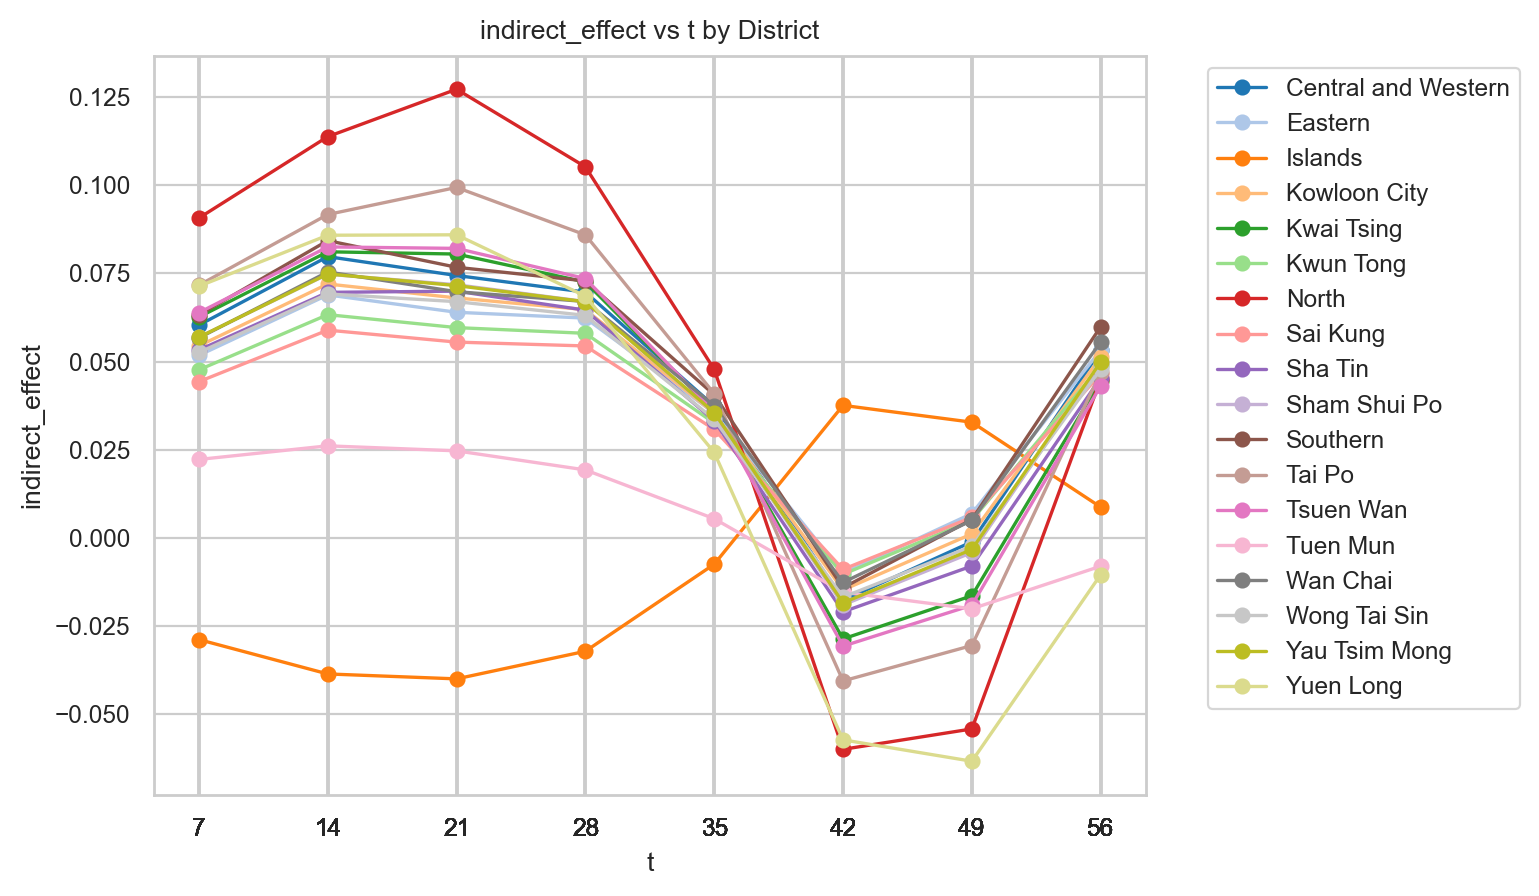

In [356]:
#保存数据用于作图
df = betas_df_3
df['indirect_effect'] = indirect_effect

# 绘制直接效应随时间和空间变化图
# 使用seaborn的调色板来分配不同颜色
color_palette = sns.color_palette('tab20', n_colors=len(df['District'].unique()))
district_color_map = {district: color for district, color in zip(df['District'].unique(), color_palette)}

# 按District分组并绘制
for district, group_data in df.groupby('District'):
    color = district_color_map[district]
    plt.plot(group_data['t'], group_data['indirect_effect'], marker='o', label=district, color=color)

plt.xlabel('t')
plt.ylabel('indirect_effect')
plt.title('indirect_effect vs t by District')
# 设置横坐标刻度为t的值
plt.xticks(df['t']) 
# 调整图例位置到图片右边空白处
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.grid(True)
plt.show()

In [357]:
#保存数据用于作图
df = betas_df_3
df['indirect_effect'] = indirect_effect

#新增疫情数据
df_covid=data[['covid_new','t']]
df_covid = df_covid.reset_index()
df['covid_new']=df_covid['covid_new']

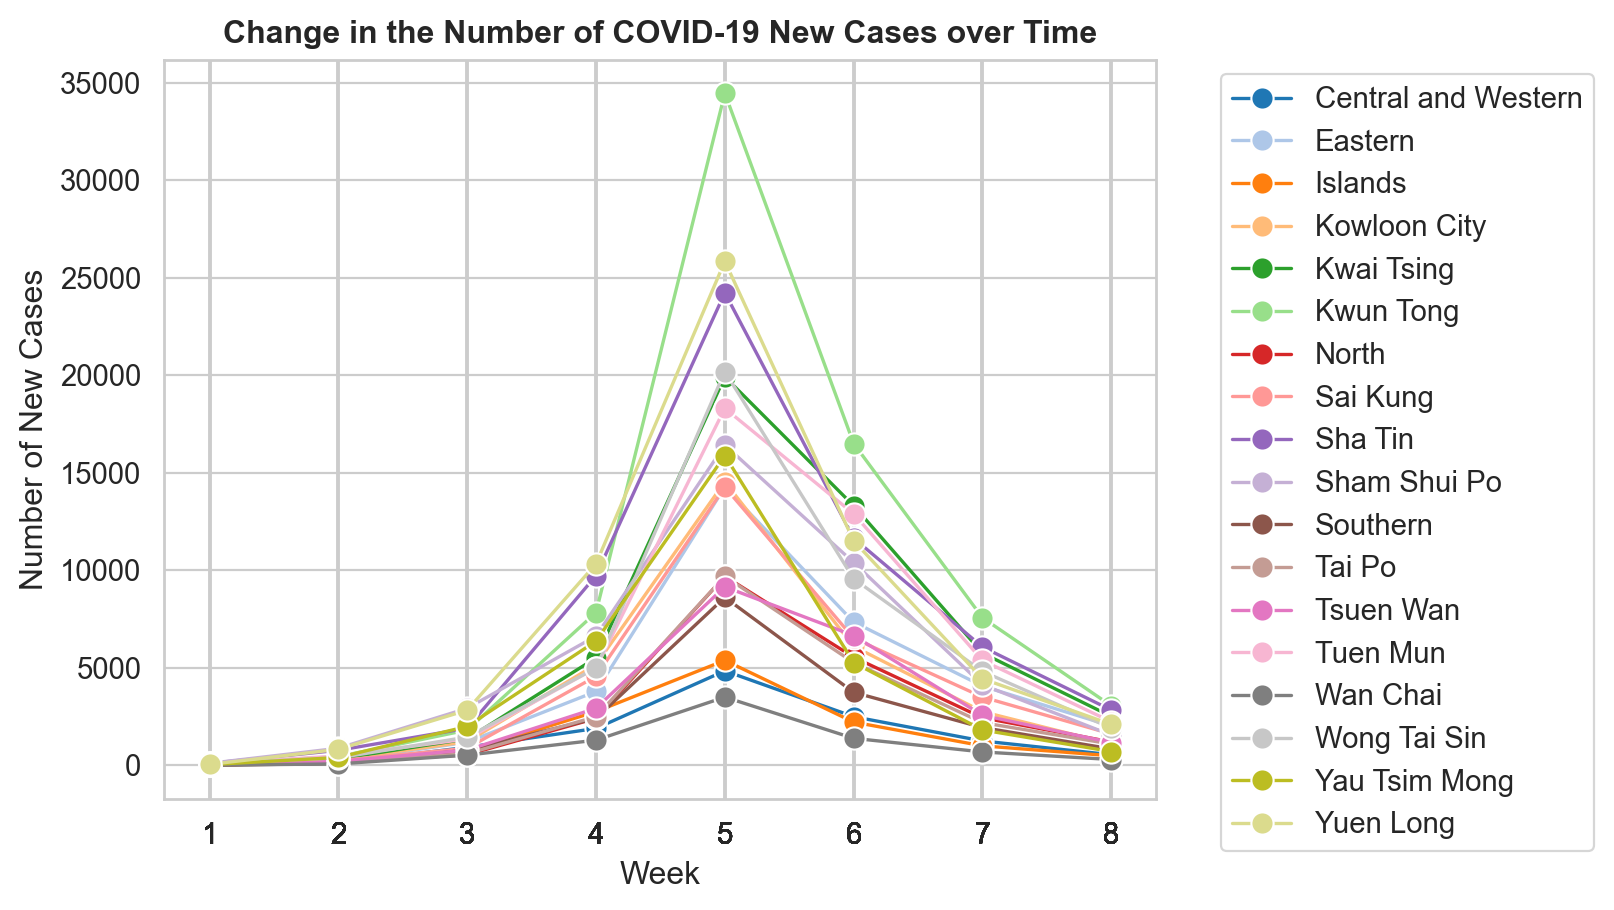

In [359]:
# 新增 week 变量表示 t
df['week'] = df['t'] // 7

# 设置 seaborn 绘图风格，学术风格通常简洁干净
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)  # 调整字体大小以适应学术风格

# 创建图形对象 fig1
fig1, ax = plt.subplots()

# 绘制线图，使用 seaborn 确保颜色不重复
sns.lineplot(data=df, x='week', y='covid_new', hue='District', marker='o', palette='tab20', ax=ax, markersize=8)

# 设置标题和轴标签
ax.set_title('Change in the Number of COVID-19 New Cases over Time', fontweight='bold')
ax.set_xlabel('Week')
ax.set_ylabel('Number of New Cases')

# 设置横坐标刻度为 week 的值
ax.set_xticks(df['week'])

# 调整图例位置到图片右边
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# 可以在此处保存图片，例如保存为 PNG 格式
# fig1.savefig('indirect_effect_plot.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

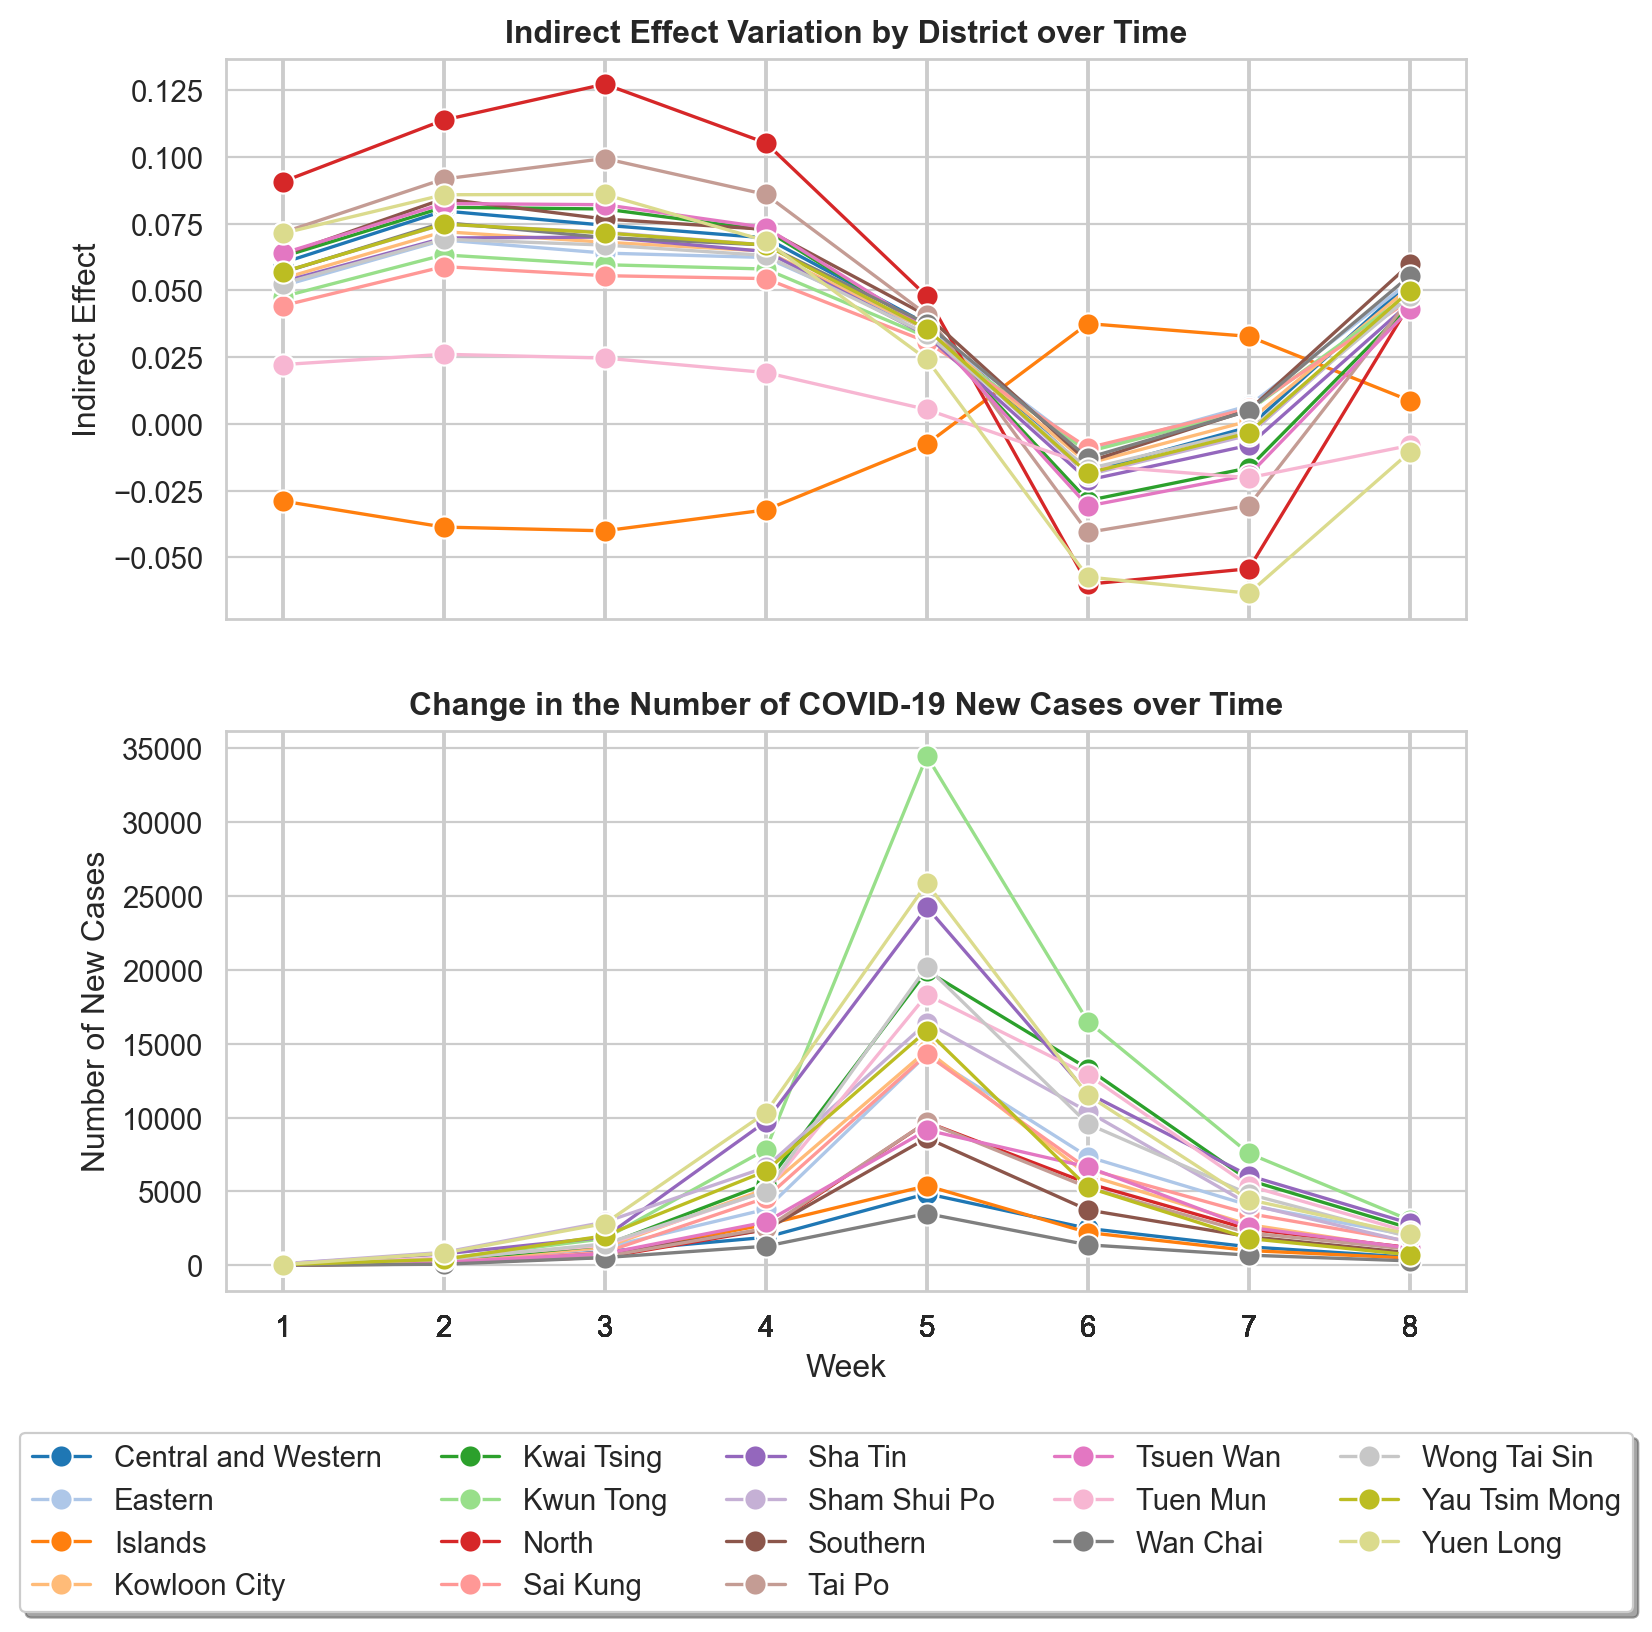

In [398]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设这里读取数据到df，你需要替换为实际的数据读取方式
# df = pd.read_csv('your_data.csv')

# 设置seaborn绘图风格，学术风格通常简洁干净
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)  # 调整字体大小以适应学术风格

# 创建包含两个子图的图形对象
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# 绘制第一个子图：中介效应随时间变化图
sns.lineplot(data=df, x='week', y='indirect_effect', hue='District', marker='o', palette='tab20', ax=ax1, markersize=8)
ax1.set_title('Indirect Effect Variation by District over Time', fontweight='bold')
ax1.set_ylabel('Indirect Effect')
ax1.get_legend().remove()  # 移除第一个子图的图例

# 绘制第二个子图：新增病例随时间变化图
sns.lineplot(data=df, x='week', y='covid_new', hue='District', marker='o', palette='tab20', ax=ax2, markersize=8)
ax2.set_title('Change in the Number of COVID-19 New Cases over Time', fontweight='bold')
ax2.set_xlabel('Week')
ax2.set_ylabel('Number of New Cases')

# 设置横坐标刻度为week的值
ax1.set_xticks(df['week'])
ax2.set_xticks(df['week'])

# 只保留一个图例，从第一个子图获取图例句柄和标签
handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()  # 移除第二个子图的原始图例

ncol_value = 5  # 根据实际情况调整列数，减少列数可缩小图例宽度
# 调整 bbox_to_anchor 横坐标
fig.legend(handles, labels, loc='lower center', 
           ncol=ncol_value, 
           bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True)

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.2)

# 保存图片
fig.savefig(path+'indirect_effect.png', dpi=600, bbox_inches='tight')

# 显示图形
plt.show()

人口密度分析

In [362]:
pop = pd.read_csv(path + 'population_density.csv')
pop

,District,pop_density_2021,pop_density_2022
0,Central and Western,18808,17820
1,Wan Chai,15791,14970
2,Eastern,29440,28810
3,Southern,6779,6620
4,Yau Tsim Mong,44458,42400
5,Sham Shui Po,46067,46220
6,Kowloon City,40994,40310
7,Wong Tai Sin,43730,43480
8,Kwun Tong,59704,59340
9,Kwai Tsing,21246,21040


In [363]:
merged_df = pd.merge(df, pop, on='District', how='left')
merged_df

,Intercept,overallSVI_avg,Food_Market,District,t,indirect_effect,covid_new,week,pop_density_2021,pop_density_2022
0,-0.760469,0.228118,-0.617644,Central and Western,7,0.060312,17.298,1,18808,17820
1,-0.154431,0.149097,-0.822835,Central and Western,14,0.079749,112.050,2,18808,17820
2,0.320400,0.102367,-0.772680,Central and Western,21,0.074395,927.537,3,18808,17820
3,0.645286,0.122014,-0.729911,Central and Western,28,0.069671,1894.750,4,18808,17820
4,0.778152,0.198574,-0.396882,Central and Western,35,0.037385,4847.310,5,18808,17820
...,...,...,...,...,...,...,...,...,...,...
139,0.878090,0.016429,-0.887717,Yuen Long,28,0.068546,10335.000,4,4825,4750
140,0.979993,0.119708,-0.317877,Yuen Long,35,0.024197,25852.320,5,4825,4750
141,1.420727,0.245796,0.762458,Yuen Long,42,-0.057309,11510.689,6,4825,4750
142,1.308006,0.265184,0.819555,Yuen Long,49,-0.063376,4442.612,7,4825,4750


In [364]:
merged_df['ln_pop_density_2022'] = np.log(merged_df['pop_density_2022'])

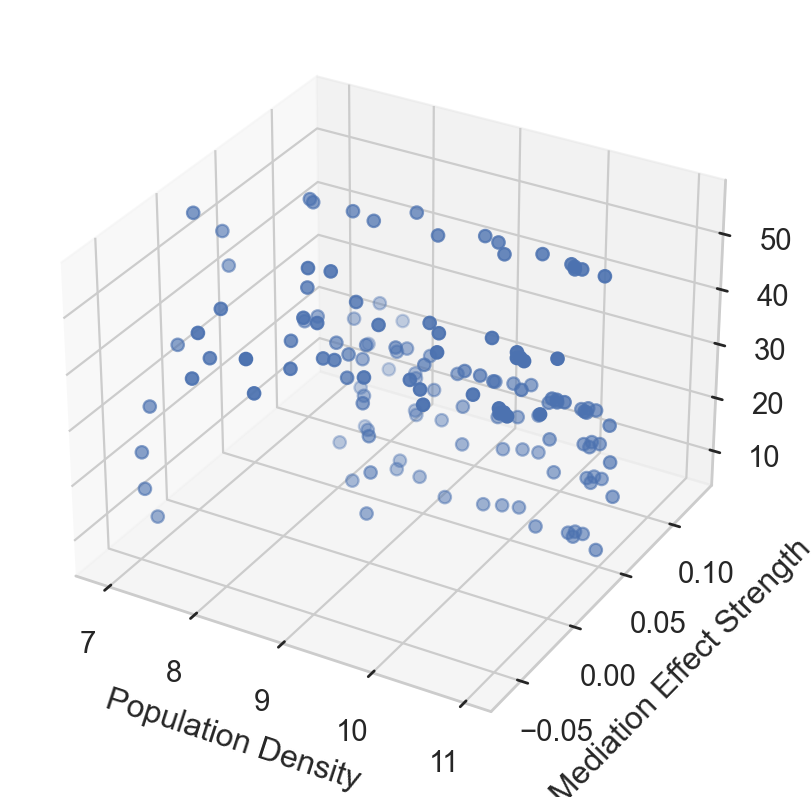

In [371]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(merged_df['ln_pop_density_2022'], merged_df['indirect_effect'], merged_df['t'])
ax.set_xlabel('Population Density')
ax.set_ylabel('Mediation Effect Strength')
ax.set_zlabel('Time t')
plt.show()
    

In [377]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# 计算皮尔逊相关系数
pearson_r, p_value_pearson = pearsonr(merged_df['ln_pop_density_2022'], merged_df['indirect_effect'])
print(f"皮尔逊相关系数: {pearson_r}, p值: {p_value_pearson}")

# 计算斯皮尔曼相关系数
spearman_r, p_value_spearman = spearmanr(merged_df['ln_pop_density_2022'], merged_df['indirect_effect'])
print(f"斯皮尔曼相关系数: {spearman_r}, p值: {p_value_spearman}")

皮尔逊相关系数: 0.15083628081211553, p值: 0.07113738049024856
斯皮尔曼相关系数: 0.09032299680932658, p值: 0.2816447579375464


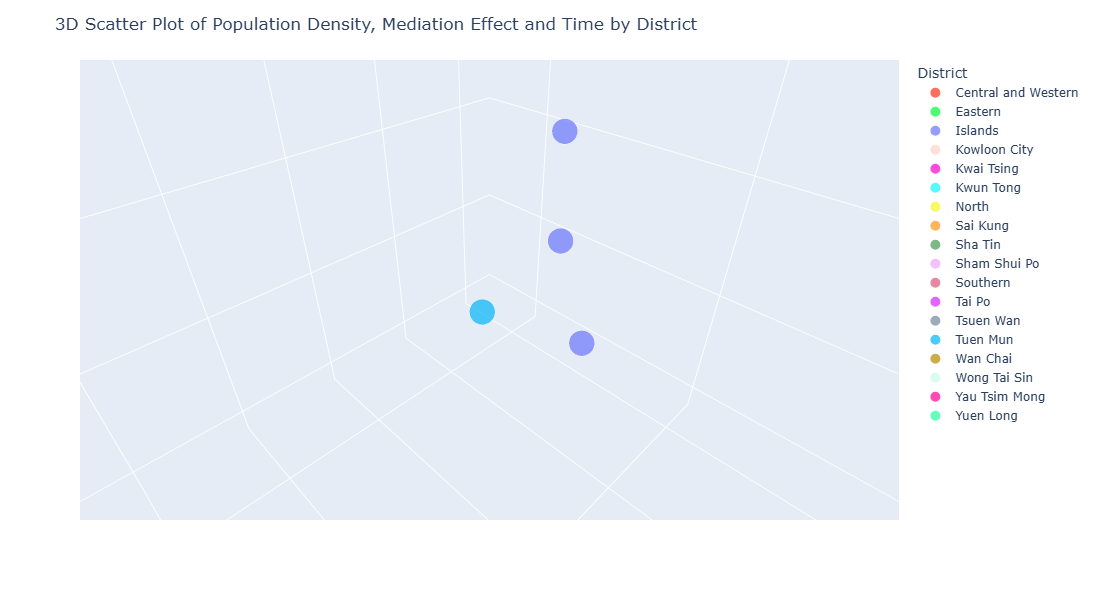

In [382]:
import plotly.express as px
import plotly.colors

# 生成包含 20 种颜色的列表
colors = plotly.colors.qualitative.Light24[:20]

# 假设 merged_df 已经正确定义
fig = px.scatter_3d(merged_df, x='ln_pop_density_2022', y='indirect_effect', z='week',
                    color='District',  # 根据 District 列来设置颜色
                    labels={
                        "ln_pop_density_2022": "Population Density",
                        "indirect_effect": "Mediation Effect Strength",
                        "t": "Time t"
                    },
                    size=[0.2] * len(merged_df),  # 点的大小
                    color_discrete_sequence=colors  # 使用自定义颜色列表
                    )

# 添加图表标题并设置宽度和高度
fig.update_layout(
    title="3D Scatter Plot of Population Density, Mediation Effect and Time by District",
    scene=dict(
        xaxis_title='pop_density_ln',
        yaxis_title='indirect_effect',
        zaxis_title='week'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=800,  # 设置宽度，单位为像素，可按需调整
    height=600  # 设置高度，单位为像素，可按需调整
)

fig.show()

In [384]:
mean_eff= df['indirect_effect'].groupby(df['District']).mean()
mean_eff

District
Central and Western    0.044466
Eastern                0.041547
Islands               -0.008517
Kowloon City           0.041509
Kwai Tsing             0.041504
Kwun Tong              0.038063
North                  0.051936
Sai Kung               0.035897
Sha Tin                0.038368
Sham Shui Po           0.041496
Southern               0.048561
Tai Po                 0.045661
Tsuen Wan              0.041371
Tuen Mun               0.006751
Wan Chai               0.044271
Wong Tai Sin           0.039251
Yau Tsim Mong          0.041734
Yuen Long              0.025589
Name: indirect_effect, dtype: float64

In [386]:
df_mean = mean_eff.to_frame()
df_mean.reset_index()

df_mean = pd.merge(df_mean, pop, on='District', how='left')
df_mean['ln_pop_density_2022'] = np.log(df_mean['pop_density_2022'])
df_mean['ln_indirect_effect'] = np.log(df_mean['indirect_effect'])
df_mean

E:\anacanda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



,District,indirect_effect,pop_density_2021,pop_density_2022,ln_pop_density_2022,ln_indirect_effect
0,Central and Western,0.044466,18808,17820,9.788077,-3.113023
1,Eastern,0.041547,29440,28810,10.268478,-3.180921
2,Islands,-0.008517,1021,1000,6.907755,NaN
3,Kowloon City,0.041509,40994,40310,10.604355,-3.181838
4,Kwai Tsing,0.041504,21246,21040,9.954181,-3.181966
5,Kwun Tong,0.038063,59704,59340,10.991039,-3.268512
6,North,0.051936,2269,2460,7.807917,-2.957742
7,Sai Kung,0.035897,3771,3800,8.242756,-3.327115
8,Sha Tin,0.038368,10082,10020,9.212338,-3.260528
9,Sham Shui Po,0.041496,46067,46220,10.741168,-3.182160


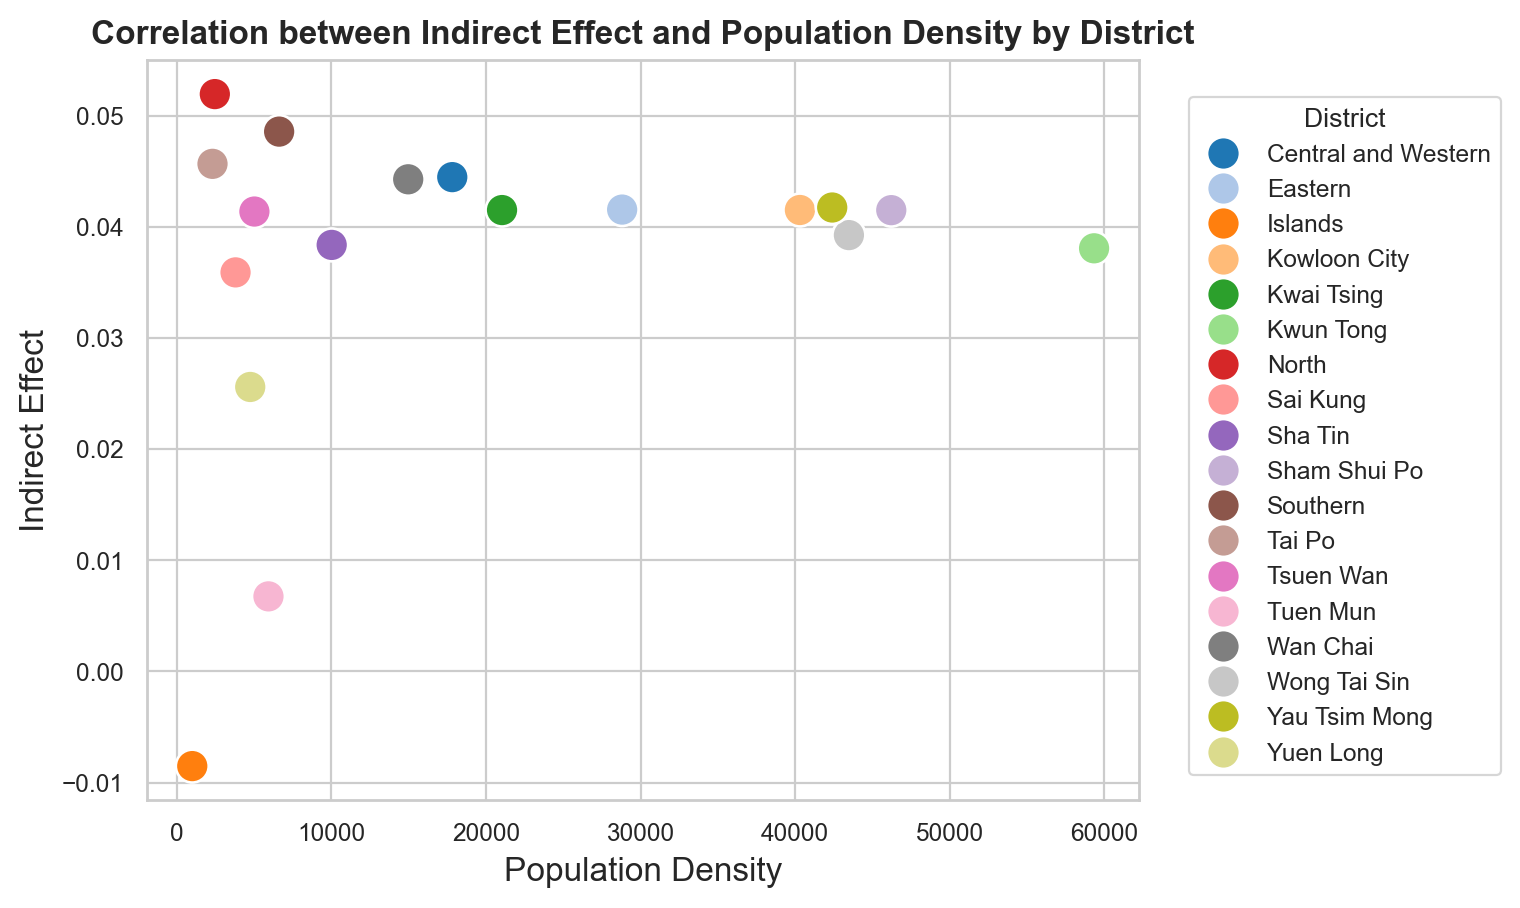

In [388]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置绘图风格（白色网格背景，学术常用配色）
sns.set(style="whitegrid", context="paper", palette="deep")

# 绘制散点图，调整marker大小（s参数）
sns.scatterplot(
    data=df_mean,
    x='pop_density_2022',  
    y='indirect_effect',  
    hue='District',  
    palette='tab20',
    s=140  # 调大marker尺寸，可根据实际效果调整
)

# 添加轴标签和标题
plt.xlabel('Population Density', fontsize = 12)
plt.ylabel('Indirect Effect',fontsize = 12)
plt.title('Correlation between Indirect Effect and Population Density by District',fontsize = 12, weight='bold')

# 调整图例位置到右侧
plt.legend(
    bbox_to_anchor=(1.05, 0.95), 
    loc='upper left', 
    borderaxespad=0.,
    title='District'  # 为图例添加标题（可选，使更清晰）
)

# 优化布局防止元素重叠

plt.show()

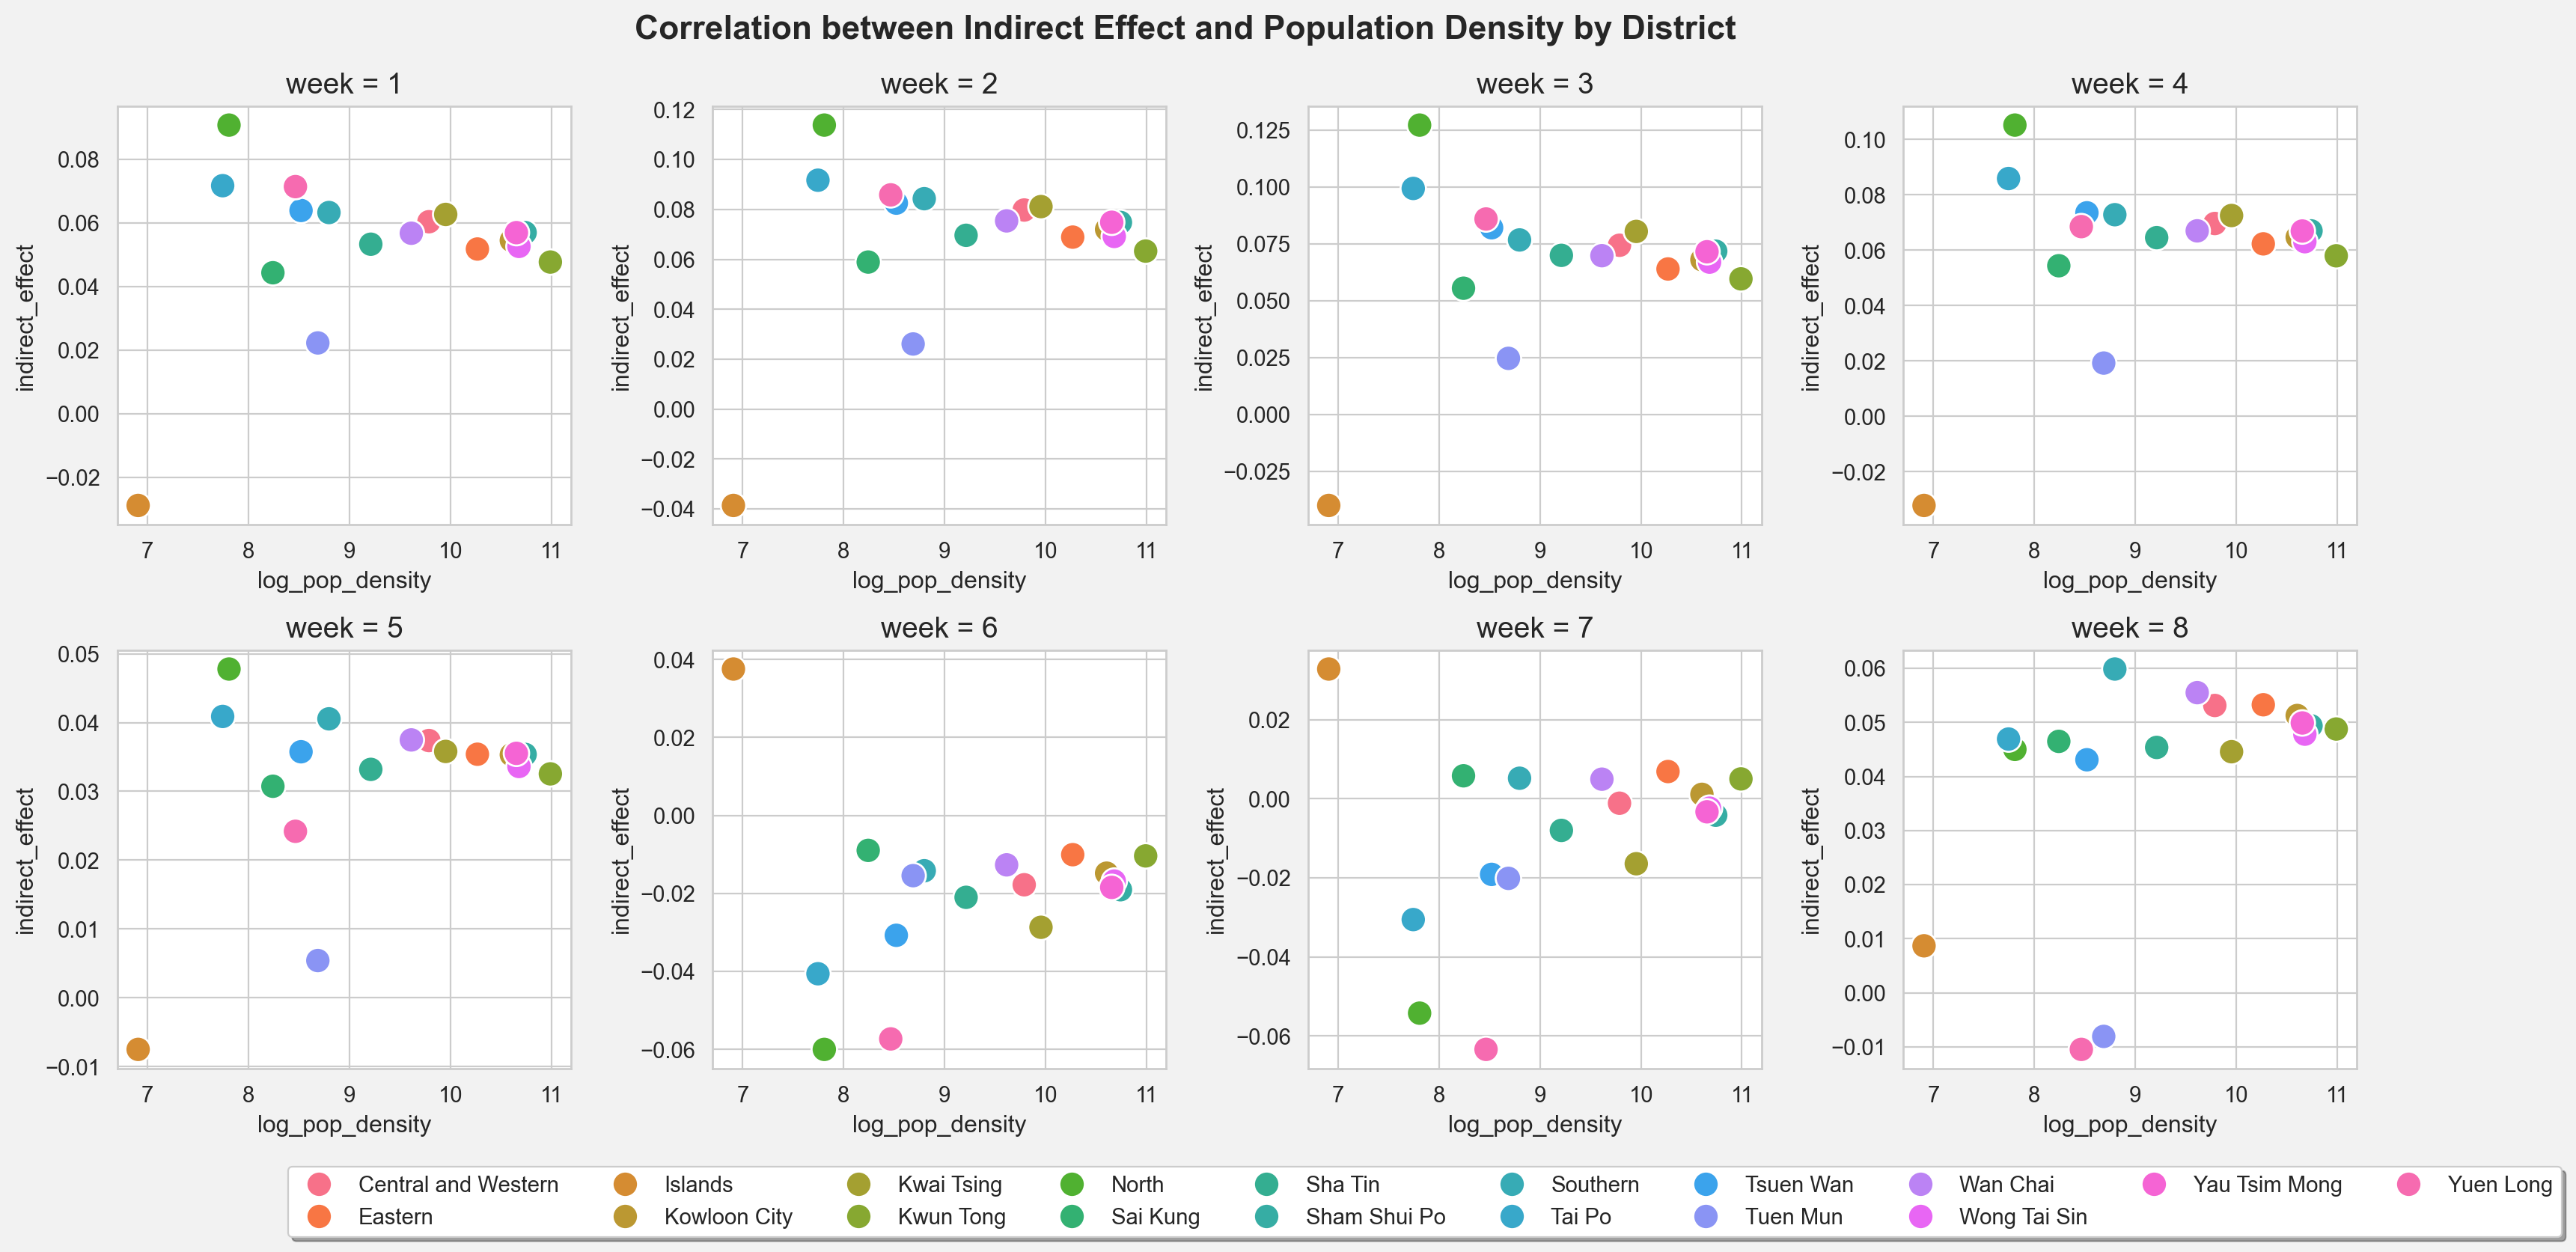

In [400]:
# 按 week 分组
groups = merged_df.groupby('week')

# 创建 2 行 4 列的子图布局
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 设置图形背景颜色
fig.patch.set_facecolor('#f2f2f2')  # 浅灰色背景

# 用于存储图例句柄和标签
handles = []
labels = []

# 遍历每个时间分组
for i, (week, group) in enumerate(groups):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    # 以不同颜色区分不同地区
    plot = sns.scatterplot(data=group, x='ln_pop_density_2022', y='indirect_effect', hue='District', ax=ax, s=150)
    ax.set_title(f'week = {week}',fontsize=14)
    ax.set_xlabel('log_pop_density')
    ax.set_ylabel('indirect_effect')

    # 获取当前子图的图例句柄和标签
    if i == 0:
        handles, labels = plot.get_legend_handles_labels()

    # 移除当前子图的图例
    ax.get_legend().remove()

# 在图片最底下添加共用的图例

ncol_value = 10  # 根据实际情况调整列数，减少列数可缩小图例宽度
# 调整 bbox_to_anchor 横坐标
fig.legend(handles, labels, loc='lower center', 
           ncol=ncol_value,  
           bbox_to_anchor=(0.6, -0.05, 0, 1),
           fancybox=True, shadow=True)

# 添加整个图形的标题
fig.suptitle('Correlation between Indirect Effect and Population Density by District', fontsize=16,fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1,hspace=0.3)  # 调整底部空白区域，为图例腾出空间
plt.show()
# fig.savefig(path+'relationship_new.png', dpi=300, bbox_inches='tight') 

In [396]:
# 存储每个组的相关系数和 p 值
correlation_results = []
p_values = []

# 遍历每个时间分组
for i, (week, group) in enumerate(groups):
    # 提取 x 和 y 列的数据
    x = group['ln_pop_density_2022']
    y = group['indirect_effect']
    # 计算皮尔逊相关系数和 p 值
    corr, p_value = pearsonr(x, y)
    correlation_results.append(corr)
    p_values.append(p_value)
    print(f"时间分组 week {week} 的相关系数: {corr}, p 值: {p_value}")

时间分组 week 1 的相关系数: 0.2396825766236046, p 值: 0.33808955705797006
时间分组 week 2 的相关系数: 0.2811540423742493, p 值: 0.2583976011539205
时间分组 week 3 的相关系数: 0.19113117198781682, p 值: 0.4474154696194613
时间分组 week 4 的相关系数: 0.2746397713576048, p 值: 0.27005897292447795
时间分组 week 5 的相关系数: 0.3745844238583553, p 值: 0.1256394095592936
时间分组 week 6 的相关系数: 0.03324262961387847, p 值: 0.8958174640804386
时间分组 week 7 的相关系数: 0.24794891953676632, p 值: 0.32117684213726294
时间分组 week 8 的相关系数: 0.46529817035538823, p 值: 0.05167566548333814


In [189]:

# 计算皮尔逊相关系数
pearson_r, p_value_pearson = pearsonr(df_mean['ln_pop_density'], df_mean['indirect_effect'])
print(f"皮尔逊相关系数: {pearson_r}, p值: {p_value_pearson}")

# 计算斯皮尔曼相关系数
spearman_r, p_value_spearman = spearmanr(df_mean['ln_pop_density'], df_mean['indirect_effect'])
print(f"斯皮尔曼相关系数: {spearman_r}, p值: {p_value_spearman}")

皮尔逊相关系数: -0.07439815480788323, p值: 0.7692235611271788
斯皮尔曼相关系数: -0.24664602683178533, p值: 0.32380881293776365


In [179]:
df_covid=data['covid_new']
df_covid = df_covid.reset_index()
df_covid

,District,Date,covid_new
0,Central and Western,2022-01-30,17.298
1,Central and Western,2022-02-06,112.050
2,Central and Western,2022-02-13,927.537
3,Central and Western,2022-02-20,1894.750
4,Central and Western,2022-02-27,4847.310
...,...,...,...
139,Yuen Long,2022-02-20,10335.000
140,Yuen Long,2022-02-27,25852.320
141,Yuen Long,2022-03-06,11510.689
142,Yuen Long,2022-03-13,4442.612


In [43]:
merged_df['covid_new']=df_covid['covid_new']

In [45]:
merged_df['covid_new_ln'] = np.log(merged_df['covid_new'])
merged_df

,Intercept,overallSVI_avg,Retail_Life_Service,District,t,indirect_effect,covid_new,week,pop_density,pop_density_ln,covid_new_ln
0,-1.676387,0.306154,0.044517,Central and Western,7,0.000328,17.298,1,18808,9.842038,2.850591
1,-0.946005,0.244637,-0.012035,Central and Western,14,-0.000097,112.050,2,18808,9.842038,4.718945
2,-0.140870,0.187285,-0.005770,Central and Western,21,-0.000050,927.537,3,18808,9.842038,6.832533
3,0.544855,0.195197,-0.072505,Central and Western,28,-0.000675,1894.750,4,18808,9.842038,7.546842
4,0.922538,0.234639,-0.048105,Central and Western,35,-0.000493,4847.310,5,18808,9.842038,8.486179
...,...,...,...,...,...,...,...,...,...,...,...
139,0.627017,0.080321,0.079436,Yuen Long,28,0.011535,10335.000,4,4825,8.481566,9.243291
140,1.049547,0.132218,0.146625,Yuen Long,35,0.021901,25852.320,5,4825,8.481566,10.160156
141,0.925261,0.176354,0.278892,Yuen Long,42,0.042621,11510.689,6,4825,8.481566,9.351031
142,0.588905,0.192417,0.298256,Yuen Long,49,0.045748,4442.612,7,4825,8.481566,8.398998


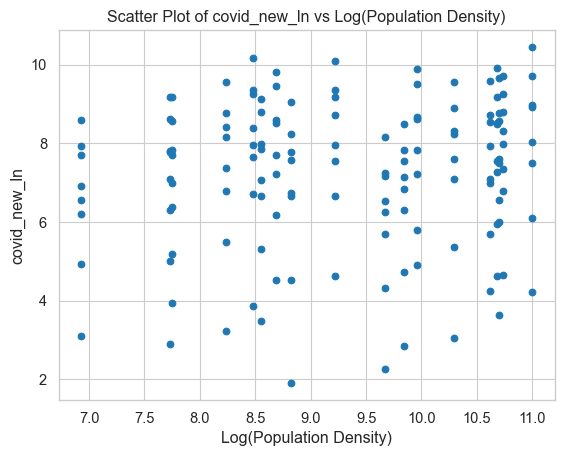

In [47]:
# 绘制散点图
plt.scatter(merged_df['pop_density_ln'], merged_df['covid_new_ln'])

# 添加标题和标签
plt.title('Scatter Plot of covid_new_ln vs Log(Population Density)')
plt.xlabel('Log(Population Density)')
plt.ylabel('covid_new_ln')

# 显示网格线
plt.grid(True)

# 显示图形
plt.show()

In [56]:
#控制变量数
X1 = ['overallSVI_avg',                   #所有自变量
      #'Tourist_Attraction'
      #'Retail_Life_Service'
      #'stay_inv_work'
      #'Food_Market', 
      #'Hospital', 'Recreation', 'Tourist_Attraction', 'Transportation_Service'
     ]
X2 = ['overallSVI_avg', #'Food_Market', #第二个变量为中介变量
      #'Retail_Life_Service',
      #'Tourist_Attraction',
      #'stay_inv_work','Retail_Life_Service', 'Food_Market',
      'Hospital'
      #, 'Recreation', 'Tourist_Attraction', 'Transportation_Service'
     ]

#总效应模型：Y = cX + e
#检验自变量与因变量关系
betas_df_1 = run_GTWR(data, X1, y)

#自变量对中介变量回归：M = aX + e
M = 'Hospital'  #可调整中介变量
betas_df_2 = run_GTWR(data, X1, M)

#直接效应模型： Y = c'X + bM + e
#检验自变量、中介变量与因变量关系
betas_df_3 = run_GTWR(data, X2, y)

#中介变量对因变量的回归；Y=b'M + e
M=['Hospital']
betas_df_4 = run_GTWR(data, M, y)

# 读取回归系数矩阵
c = betas_df_1.iloc[:, 1] # 总效应系数
c1 = betas_df_3.iloc[:, 1] # 直接效应系数(直接效应模型中自变量对因变量的回归系数)
b = betas_df_3.iloc[:, 2] # 直接效应模型中中介变量对因变量的的回归系数
a = betas_df_2.iloc[:, 1] # 自变量对中介变量的回归系数
indirect_effect = a*b # 中介效应

import numpy as np

def bootstrap_mediation(eff, n_bootstrap=1000):
    eff_values = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(eff), size=len(eff), replace=True)
        eff_sample = eff[indices]
        eff_values.append(np.mean(eff_sample))
    eff_values = np.array(eff_values)
    lower_ci = np.percentile(eff_values, 2.5)
    upper_ci = np.percentile(eff_values, 97.5)
    return lower_ci, upper_ci

lower_ci, upper_ci = bootstrap_mediation(indirect_effect)
print(f"中介效应的95%置信区间为：[{lower_ci}, {upper_ci}]")

bw:  0.1 , tau:  0.1 , score:  83.1407218875535
bw:  0.1 , tau:  0.1 , score:  83.1407218875535
R²: 0.9256467110996182
AICc: 83.1407218875535
Adjusted R²: 0.9135818661085543
bw:  0.2 , tau:  0.1 , score:  419.3088903302021
bw:  0.2 , tau:  0.1 , score:  419.3088903302021
R²: 0.035403386427361294
AICc: 419.3088903302021
Adjusted R²: -0.010967965949746583
bw:  0.1 , tau:  0.1 , score:  89.31512317008978
bw:  0.1 , tau:  0.1 , score:  89.31512317008978
R²: 0.9322139468898821
AICc: 89.31512317008978
Adjusted R²: 0.9166273314090887
bw:  0.1 , tau:  0.1 , score:  143.8260770610787
bw:  0.1 , tau:  0.1 , score:  143.8260770610787
R²: 0.8850942007140874
AICc: 143.8260770610787
Adjusted R²: 0.8672453733351744
中介效应的95%置信区间为：[0.0003459641599321022, 0.0007243725169279534]


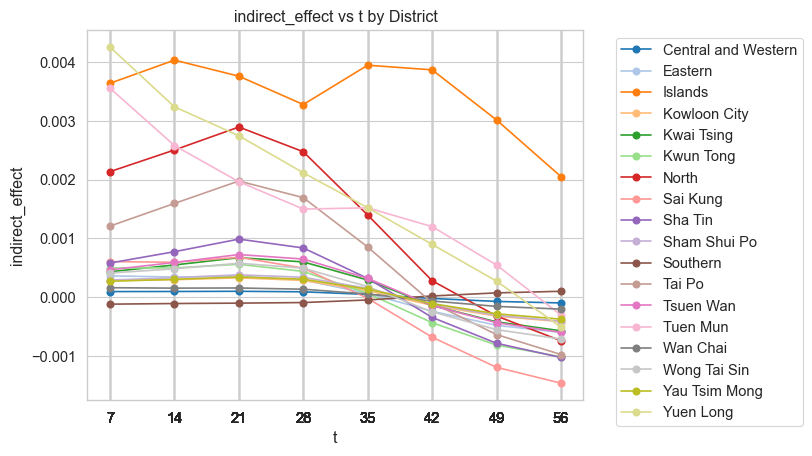

In [58]:
#保存数据用于作图
df = betas_df_3
df['indirect_effect'] = indirect_effect

# 绘制直接效应随时间和空间变化图
# 使用seaborn的调色板来分配不同颜色
color_palette = sns.color_palette('tab20', n_colors=len(df['District'].unique()))
district_color_map = {district: color for district, color in zip(df['District'].unique(), color_palette)}

# 按District分组并绘制
for district, group_data in df.groupby('District'):
    color = district_color_map[district]
    plt.plot(group_data['t'], group_data['indirect_effect'], marker='o', label=district, color=color)

plt.xlabel('t')
plt.ylabel('indirect_effect')
plt.title('indirect_effect vs t by District')
# 设置横坐标刻度为t的值
plt.xticks(df['t']) 
# 调整图例位置到图片右边空白处
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.grid(True)
plt.show()

跨区工作分析

In [156]:
work_pl = pd.read_csv(path + 'plw.csv')
work_pl

,District,plw_same_p,plw_diff_p,plw_hm_p,other_p
0,Central and Western,0.331259,0.376209,0.190434,0.102099
1,Wan Chai,0.188924,0.458976,0.239890,0.112210
2,Eastern,0.215702,0.517898,0.126507,0.139893
3,Southern,0.204324,0.501256,0.159561,0.134860
4,Yau Tsim Mong,0.231726,0.479610,0.127249,0.161415
5,Sham Shui Po,0.141062,0.581424,0.083553,0.193960
6,Kowloon City,0.126665,0.570792,0.147855,0.154689
7,Wong Tai Sin,0.096483,0.647440,0.060131,0.195946
8,Kwun Tong,0.214637,0.521450,0.060574,0.203338
9,Kwai Tsing,0.133595,0.603754,0.056133,0.206518


In [158]:
work_pl.describe()

,plw_same_p,plw_diff_p,plw_hm_p,other_p
count,18.000000,18.000000,18.000000,18.000000
mean,0.165768,0.552883,0.111588,0.169761
std,0.061558,0.069464,0.049439,0.034681
min,0.080319,0.376209,0.056133,0.102099
25%,0.127202,0.518786,0.071938,0.151627
50%,0.147214,0.564669,0.108184,0.169307
75%,0.210791,0.602331,0.127063,0.197641
max,0.331259,0.647440,0.239890,0.225515


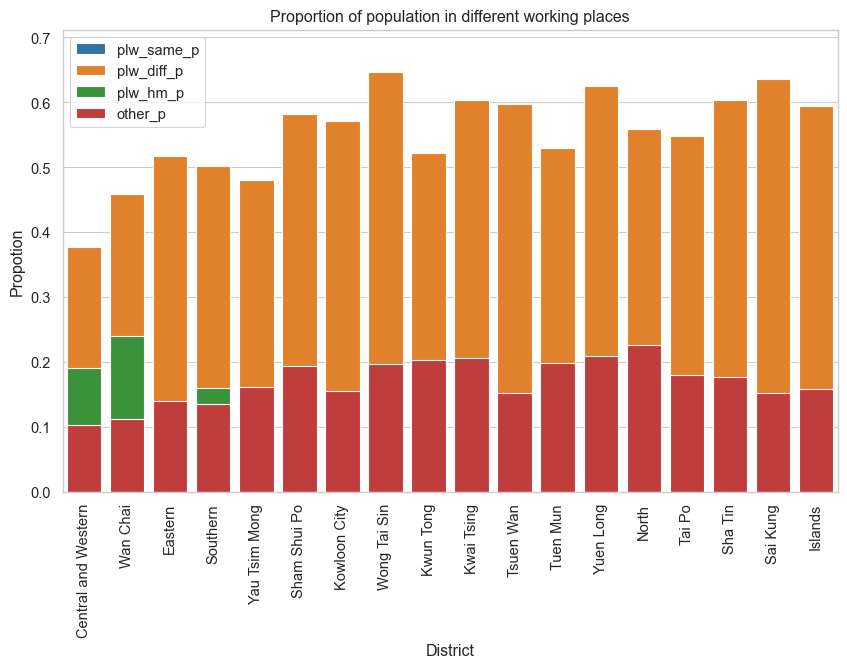

In [166]:
fig1=plt.figure(figsize=(10, 6))
sns.barplot(x='District', y='plw_same_p', data=work_pl, label='plw_same_p')
sns.barplot(x='District', y='plw_diff_p', data=work_pl, label='plw_diff_p')
sns.barplot(x='District', y='plw_hm_p', data=work_pl, label='plw_hm_p')
sns.barplot(x='District', y='other_p', data=work_pl, label='other_p')
plt.xlabel('District')
plt.ylabel('Propotion')
plt.title('Proportion of population in different working places')

plt.ylim(0, max(work_pl[['plw_same_p', 'plw_diff_p', 'plw_hm_p', 'other_p']].values.flatten()) * 1.1)
plt.xticks(rotation=90)

plt.legend()
plt.show()

# 保存图片
fig1.savefig(path+'Propotion.png', dpi=300, bbox_inches='tight')

In [168]:
merged_df2= pd.merge(merged_df, work_pl, on='District', how='left')
merged_df2

,Intercept,overallSVI_avg,Retail_Life_Service,District,t,indirect_effect,week,covid_new,pop_density,pop_density_ln,covid_new_ln,plw_same_p,plw_diff_p,plw_hm_p,other_p
0,-1.676387,0.306154,0.044517,Central and Western,7,0.000328,1,17.298,18808,9.842038,2.850591,0.331259,0.376209,0.190434,0.102099
1,-0.946005,0.244637,-0.012035,Central and Western,14,-0.000097,2,112.050,18808,9.842038,4.718945,0.331259,0.376209,0.190434,0.102099
2,-0.140870,0.187285,-0.005770,Central and Western,21,-0.000050,3,927.537,18808,9.842038,6.832533,0.331259,0.376209,0.190434,0.102099
3,0.544855,0.195197,-0.072505,Central and Western,28,-0.000675,4,1894.750,18808,9.842038,7.546842,0.331259,0.376209,0.190434,0.102099
4,0.922538,0.234639,-0.048105,Central and Western,35,-0.000493,5,4847.310,18808,9.842038,8.486179,0.331259,0.376209,0.190434,0.102099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.627017,0.080321,0.079436,Yuen Long,28,0.011535,4,10335.000,4825,8.481566,9.243291,0.080319,0.624688,0.085749,0.209244
140,1.049547,0.132218,0.146625,Yuen Long,35,0.021901,5,25852.320,4825,8.481566,10.160156,0.080319,0.624688,0.085749,0.209244
141,0.925261,0.176354,0.278892,Yuen Long,42,0.042621,6,11510.689,4825,8.481566,9.351031,0.080319,0.624688,0.085749,0.209244
142,0.588905,0.192417,0.298256,Yuen Long,49,0.045748,7,4442.612,4825,8.481566,8.398998,0.080319,0.624688,0.085749,0.209244


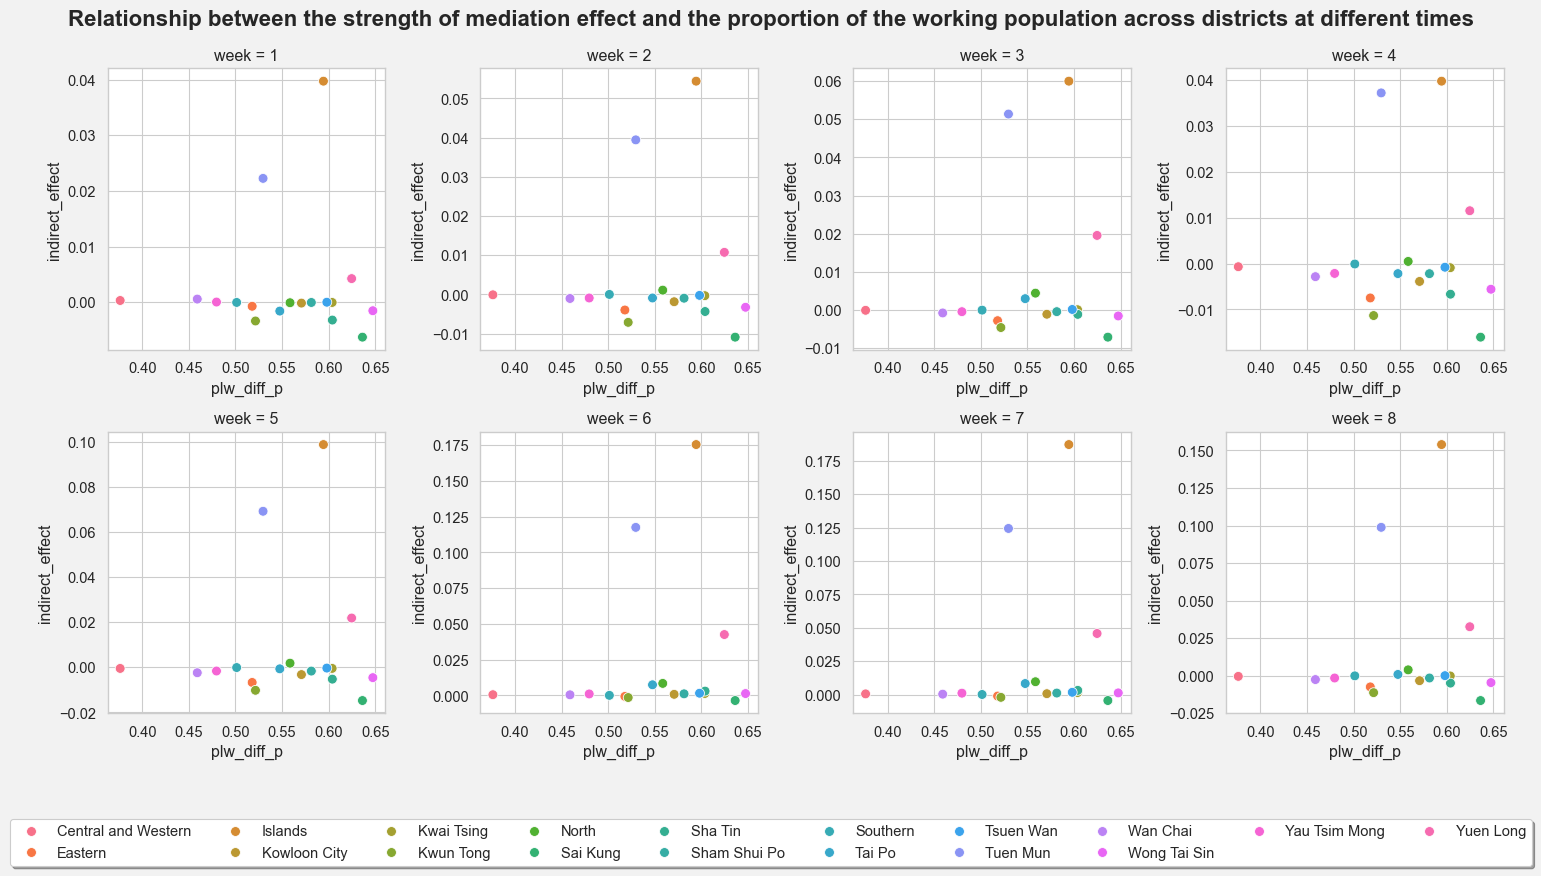

In [194]:
# 按 week 分组
groups = merged_df2.groupby('week')

# 创建 2 行 4 列的子图布局
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

# 设置图形背景颜色
fig.patch.set_facecolor('#f2f2f2')  # 浅灰色背景

# 用于存储图例句柄和标签
handles = []
labels = []

# 遍历每个时间分组
for i, (week, group) in enumerate(groups):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    # 以不同颜色区分不同地区
    plot = sns.scatterplot(data=group, x='plw_diff_p', y='indirect_effect', hue='District', ax=ax, s=100)
    ax.set_title(f'week = {week}')
    ax.set_xlabel('plw_diff_p')
    ax.set_ylabel('indirect_effect')

    # 获取当前子图的图例句柄和标签
    if i == 0:
        handles, labels = plot.get_legend_handles_labels()

    # 移除当前子图的图例
    ax.get_legend().remove()

# 在图片最底下添加共用的图例

ncol_value = 10  # 根据实际情况调整列数，减少列数可缩小图例宽度
# 调整 bbox_to_anchor 横坐标
fig.legend(handles, labels, loc='lower center', 
           ncol=ncol_value, 
           bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True)

# 添加整个图形的标题
fig.suptitle('Relationship between the strength of mediation effect and the proportion of the working population across districts at different times', fontsize=16,fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # 调整底部空白区域，为图例腾出空间
plt.show()
fig.savefig(path+'relationship.png', dpi=300, bbox_inches='tight')    

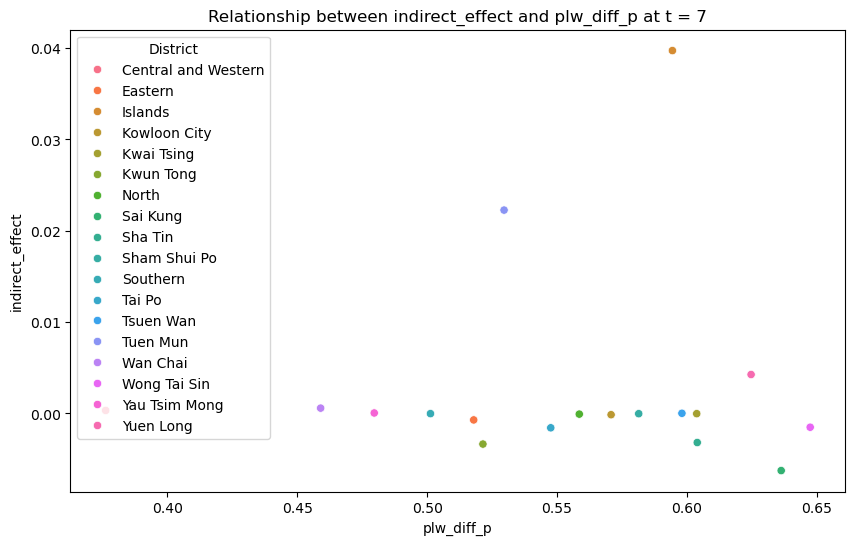

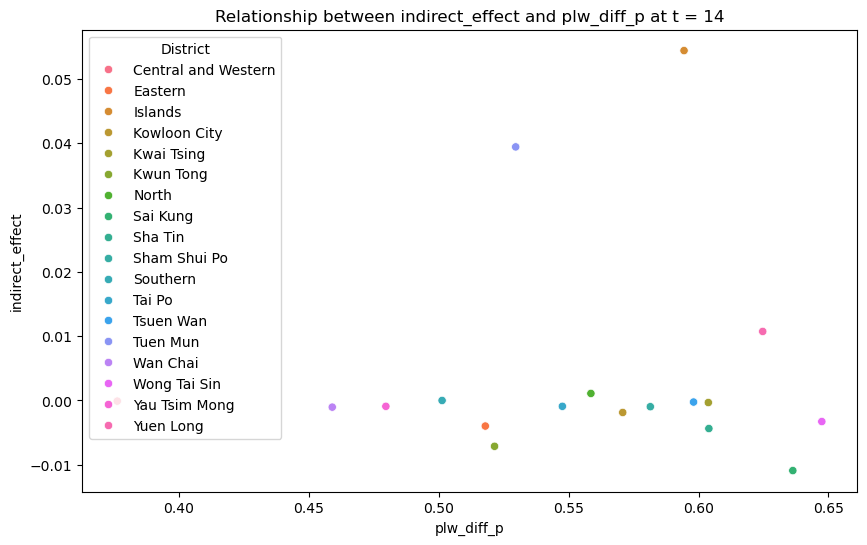

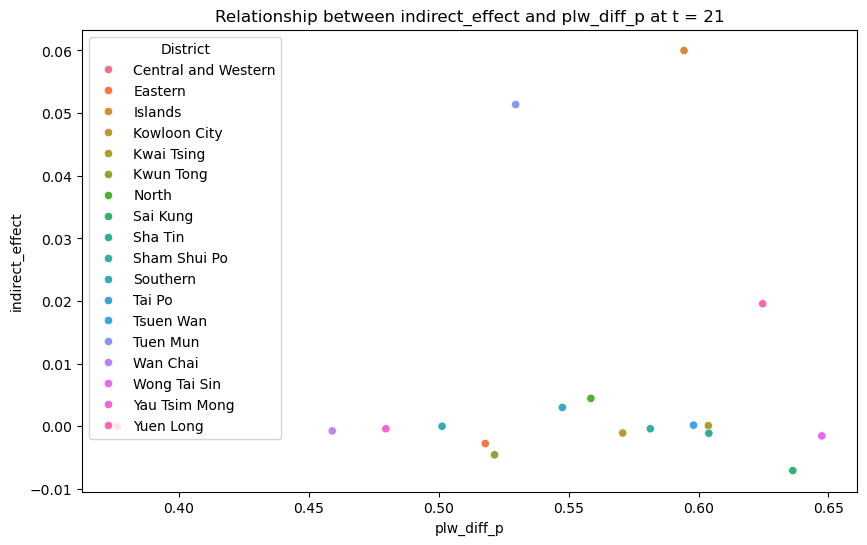

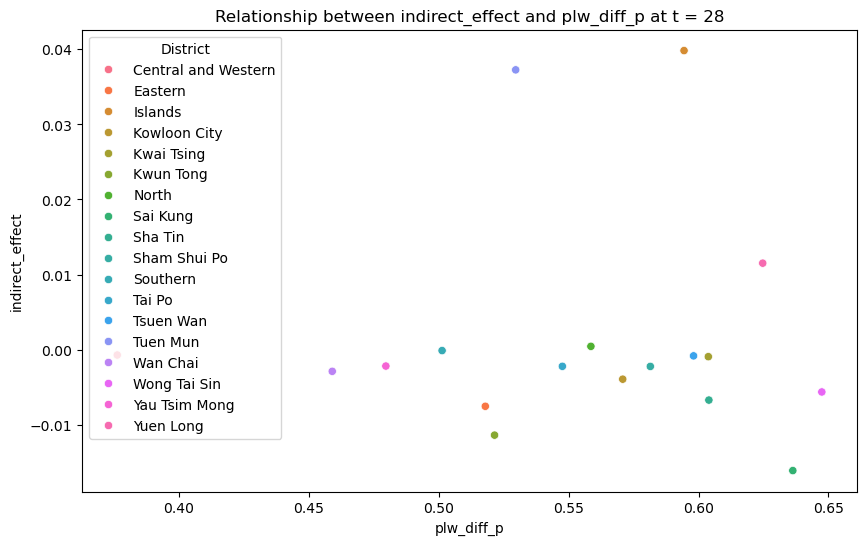

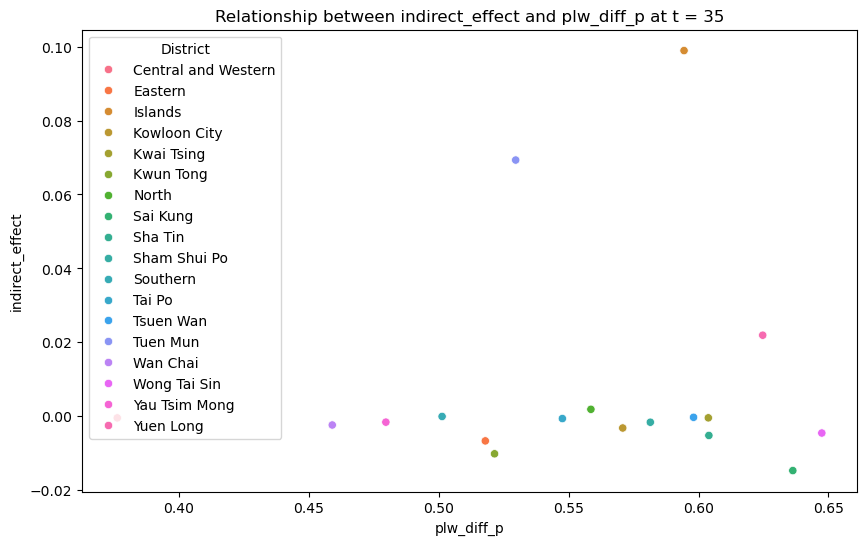

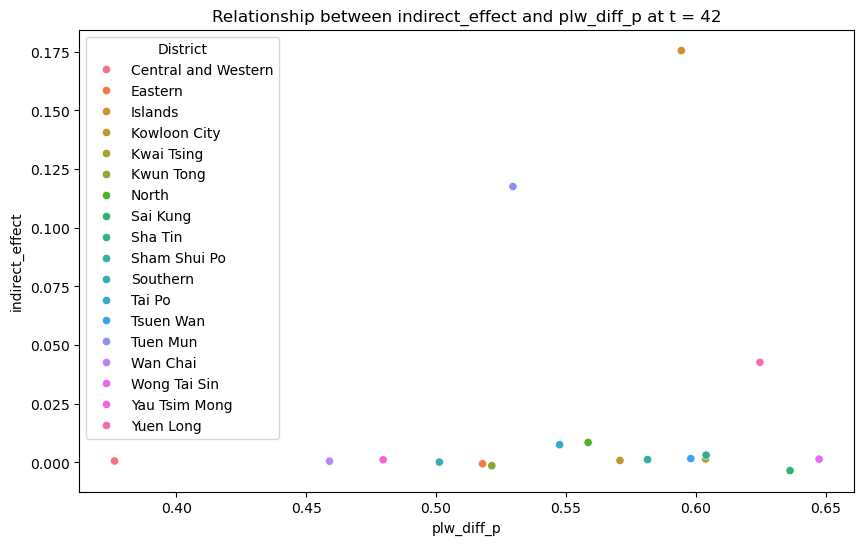

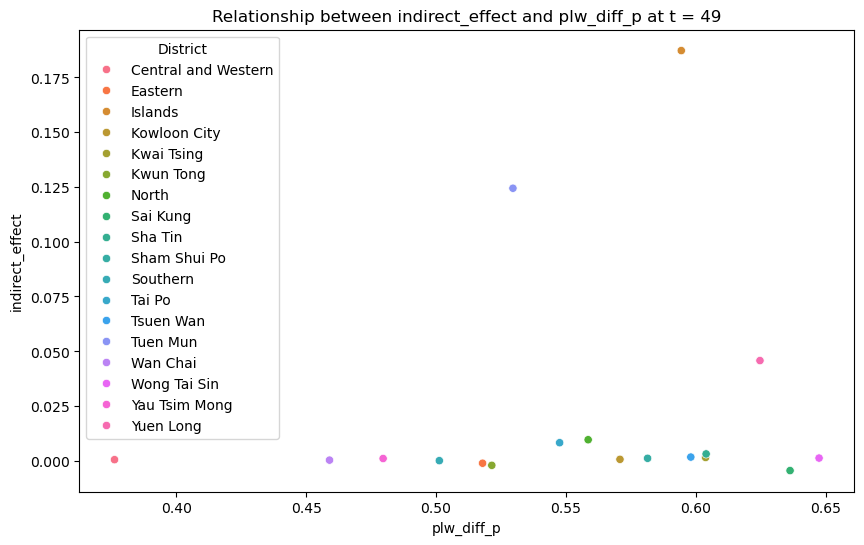

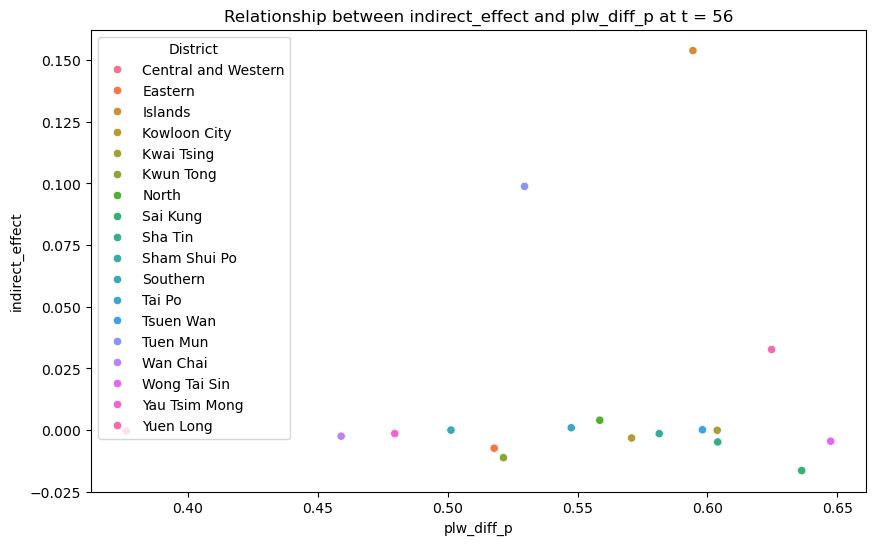

In [277]:
# 按 t 分组
groups = merged_df2.groupby('week')

# 遍历每个时间分组
for t, group in groups:
    plt.figure(figsize=(10, 6))
    # 以不同颜色区分不同地区
    sns.scatterplot(data=group, x='plw_diff_p', y='indirect_effect', hue='District')
    plt.title(f'Relationship between indirect_effect and plw_diff_p at t = {t}')
    plt.xlabel('plw_diff_p')
    plt.ylabel('indirect_effect')
    plt.legend(title='District')
    plt.show()

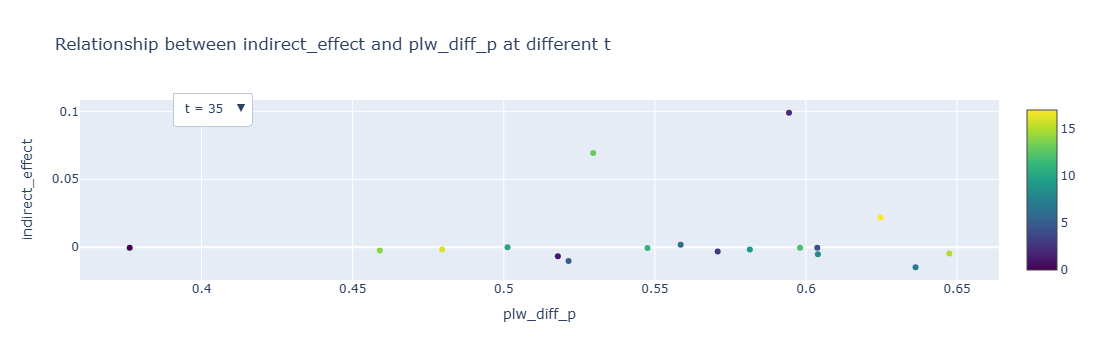

In [299]:
import plotly.graph_objects as go

# 获取所有唯一的 t 值
unique_t = sorted(merged_df2['t'].unique())

# 创建一个 Figure 对象
fig = go.Figure()

# 为每个 t 值创建一个散点图
for t in unique_t:
    df_t = merged_df2[merged_df2['t'] == t]
    fig.add_trace(
        go.Scatter(
            x=df_t['plw_diff_p'],
            y=df_t['indirect_effect'],
            mode='markers',
            name=f't = {t}',
            visible=(t == unique_t[0]),  # 只显示第一个 t 的散点图
            marker=dict(
                color=pd.Categorical(df_t['District']).codes,
                colorscale='Viridis',
                showscale=True
            ),
            text=df_t['District'],  # 指定每个点显示的文本为 District
            hoverinfo='text+x+y'  # 鼠标悬停时显示文本、x 值和 y 值
        )
    )

# 创建时间选择器
updatemenus = [
    dict(
        buttons=list([
            dict(
                args=[{'visible': [t_val == t for t_val in unique_t]}],
                label=f't = {t}',
                method='update'
            ) for t in unique_t
        ]),
        direction='down',
        pad={'r': 10, 't': 10},
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.1,
        yanchor='top'
    )
]

# 更新图形布局
fig.update_layout(
    title='Relationship between indirect_effect and plw_diff_p at different t',
    xaxis_title='plw_diff_p',
    yaxis_title='indirect_effect',
    updatemenus=updatemenus
)

# 显示图形
fig.show()
    